In [ ]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import re 
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

import tensorflow as tf

from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

!pip install transformers datasets -q

#import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
#from torch.utils.data import Dataset
import pandas as pd
import numpy as np


from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv("/kaggle/input/emails/emails.csv")
data.head()

,Text,Spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [3]:
data.shape

(5728, 2)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    5728 non-null   object
 1   Spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [5]:
data.describe()

,Spam
count,5728.000000
mean,0.238827
std,0.426404
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [6]:
data.isna().sum()

Text    0
Spam    0
dtype: int64

In [7]:
data['Spam'].unique()

array([1, 0])

In [8]:
data['Spam'].value_counts()

Spam
0    4360
1    1368
Name: count, dtype: int64

### Text Preprocessing

In [9]:
import nltk

In [10]:
from nltk import word_tokenize

def count_words(text):
    words = word_tokenize(text)
    return len(words)

In [11]:
data['Count']=data['Text'].apply(count_words)
data.head()

,Text,Spam,Count
0,Subject: naturally irresistible your corporate...,1,325
1,Subject: the stock trading gunslinger fanny i...,1,90
2,Subject: unbelievable new homes made easy im ...,1,88
3,Subject: 4 color printing special request add...,1,99
4,"Subject: do not have money , get software cds ...",1,53


In [12]:
data['Count']

0       325
1        90
2        88
3        99
4        53
       ... 
5723    298
5724    245
5725    516
5726    277
5727    445
Name: Count, Length: 5728, dtype: int64

In [13]:
data.groupby('Spam')['Count'].mean()

Spam
0    346.833028
1    267.896199
Name: Count, dtype: float64

#### Removing Punctuations and Stopwords

In [14]:
import string
from nltk.corpus import stopwords

In [15]:
def process_text(text):
    no_punc = [char for char in text if char not in string.punctuation]
    no_punc = ''.join(no_punc)
    
    
    return ' '.join([word for word in no_punc.split() if word.lower() not in stopwords.words('english')])

In [16]:
data['Text']=data['Text'].apply(process_text)
data['Text']

0       Subject naturally irresistible corporate ident...
1       Subject stock trading gunslinger fanny merrill...
2       Subject unbelievable new homes made easy im wa...
3       Subject 4 color printing special request addit...
4       Subject money get software cds software compat...
                              ...                        
5723    Subject research development charges gpg forwa...
5724    Subject receipts visit jim thanks invitation v...
5725    Subject enron case study update wow day super ...
5726    Subject interest david please call shirley cre...
5727    Subject news aurora 5 2 update aurora version ...
Name: Text, Length: 5728, dtype: object

##### Stemming

In [17]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stemming (text):
    return ''.join([stemmer.stem(word) for word in text])

In [18]:
data['Text']=data['Text'].apply(stemming)
data.head()

,Text,Spam,Count
0,subject naturally irresistible corporate ident...,1,325
1,subject stock trading gunslinger fanny merrill...,1,90
2,subject unbelievable new homes made easy im wa...,1,88
3,subject 4 color printing special request addit...,1,99
4,subject money get software cds software compat...,1,53


#### Bag of words model

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer= CountVectorizer()
message_bow = vectorizer.fit_transform(data['Text'])

In [20]:
#vectorizer.get_feature_names()
message_bow.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

#### splitting the data into train and tes data

In [21]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(message_bow,data['Spam'],test_size=0.30, random_state=42)

In [22]:
X_train.shape

(4009, 37187)

In [23]:
X_test.shape

(1719, 37187)

## SVM Classifier

In [24]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train,y_train)

SVC()

In [25]:
y_pred = svm.predict(X_test)

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1278
           1       0.99      0.91      0.95       441

    accuracy                           0.98      1719
   macro avg       0.98      0.96      0.97      1719
weighted avg       0.98      0.98      0.98      1719



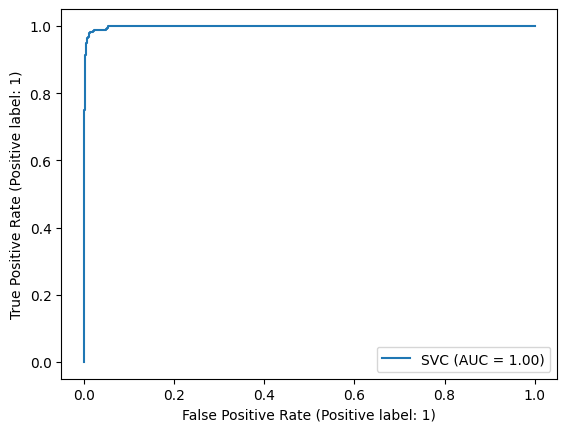

In [27]:
from sklearn.metrics import RocCurveDisplay


RocCurveDisplay.from_estimator(svm, X_test, y_test)


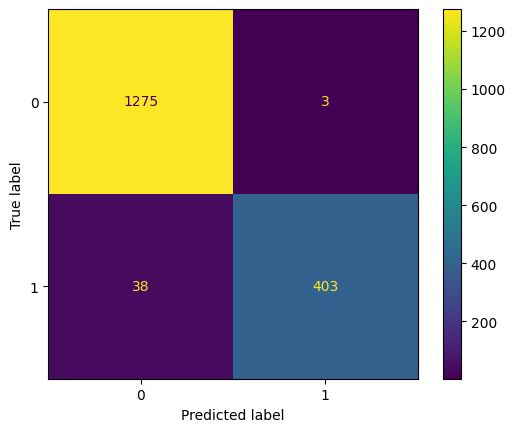

In [28]:

from sklearn.metrics import ConfusionMatrixDisplay

# Plot the confusion matrix using the trained model
ConfusionMatrixDisplay.from_estimator(svm, X_test, y_test)


41 have been misclassified

#### Accuracy using cross validation

In [29]:
from sklearn.model_selection import KFold, cross_val_score
kfold = KFold(n_splits=5,shuffle=True)
print("Accuracy using Cross Validation is :",np.mean(cross_val_score(svm,message_bow,data['Spam'],cv=kfold,scoring="accuracy"))*100," %")

Accuracy using Cross Validation is : 97.87006256811235  %


## NaiveBayesMultinomial Classifier¶

In [30]:
from sklearn.naive_bayes import MultinomialNB
nb= MultinomialNB()
nb.fit(X_train,y_train)

MultinomialNB()

In [31]:
y_pred = nb.predict(X_test)

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1278
           1       0.97      0.99      0.98       441

    accuracy                           0.99      1719
   macro avg       0.98      0.99      0.99      1719
weighted avg       0.99      0.99      0.99      1719



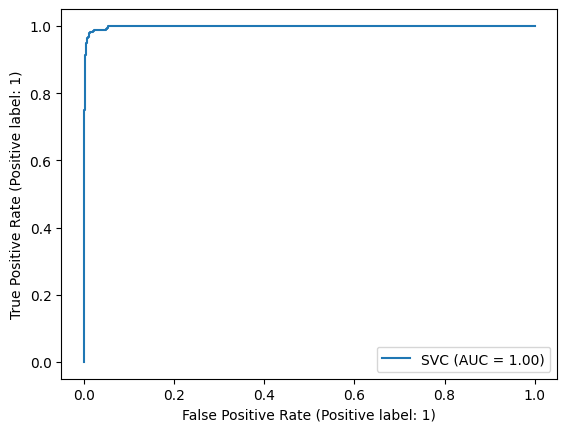

In [33]:
from sklearn.metrics import RocCurveDisplay


RocCurveDisplay.from_estimator(svm, X_test, y_test)


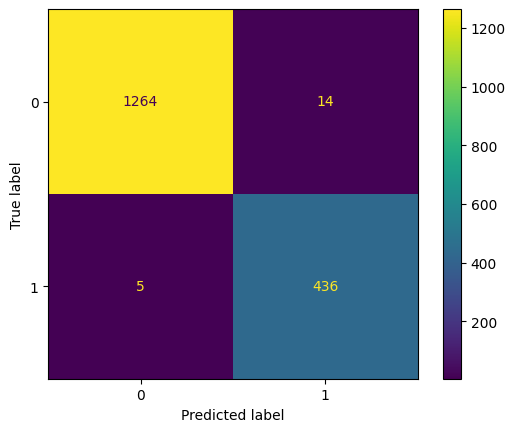

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot the confusion matrix using the trained model
ConfusionMatrixDisplay.from_estimator(nb, X_test, y_test)

17 have been misclassified

In [35]:
from sklearn.model_selection import KFold, cross_val_score
kfold = KFold(n_splits=5,shuffle=True)
print("Accuracy using Cross Validation is :",np.mean(cross_val_score(nb,message_bow,data['Spam'],cv=kfold,scoring="accuracy"))*100," %")

Accuracy using Cross Validation is : 98.95255950067445  %


In [36]:
pip install --upgrade transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 78.8 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.1
    Uninstalling transformers-4.51.1:
      Successfully uninstalled transformers-4.51.1
Note: you may need to restart the kernel to use updated packages.


In [66]:
#  Split text and labels
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['Text'], data['Spam'], test_size=0.30, random_state=42)




#2. Tokenize text using BERT tokenizer
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)

# 3. Create Dataset class
import torch
from torch.utils.data import Dataset

class EmailDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])  # .iloc for pandas Series
        return item

train_dataset = EmailDataset(train_encodings, y_train)
test_dataset = EmailDataset(test_encodings, y_test)


In [68]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [69]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [70]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)



In [41]:
from tqdm import tqdm

epochs = 3
model.train()

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    total_loss = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Average training loss: {avg_loss:.4f}")



Epoch 1/3


100%|██████████| 251/251 [06:34<00:00,  1.57s/it]


Average training loss: 0.1252

Epoch 2/3


100%|██████████| 251/251 [06:45<00:00,  1.61s/it]


Average training loss: 0.0312

Epoch 3/3


100%|██████████| 251/251 [06:45<00:00,  1.61s/it]

Average training loss: 0.0117


In [ ]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)

        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"\nTest Accuracy: {accuracy:.4f}")


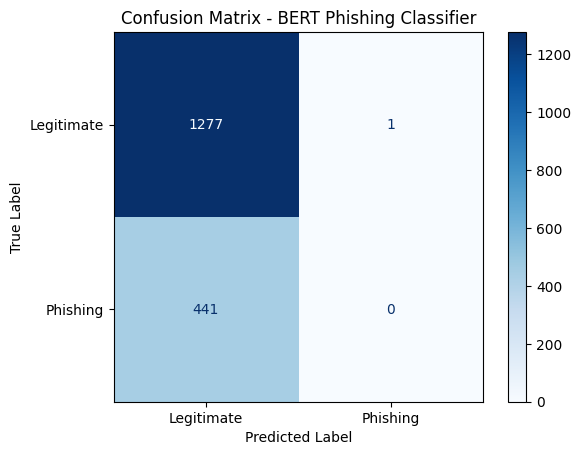

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Store predictions and true labels
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Step 2: Generate and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legitimate', 'Phishing'])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - BERT Phishing Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


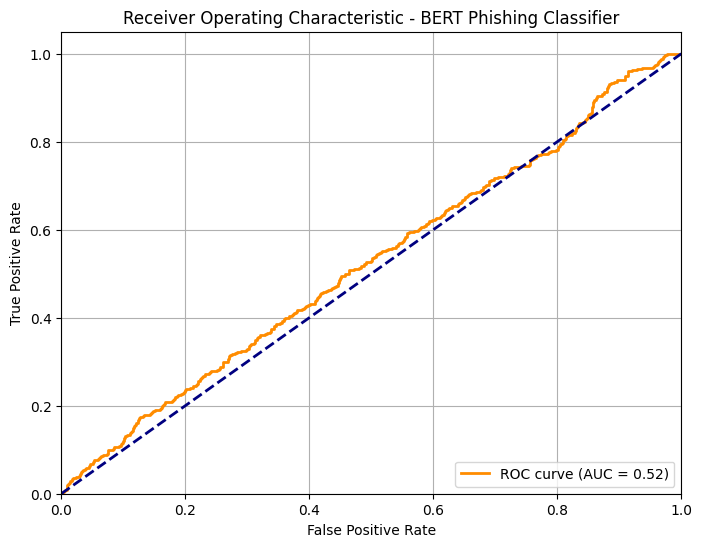

In [72]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Store probabilities and true labels
y_true = []
y_scores = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)  # Get probabilities
        positive_probs = probs[:, 1]  # Probability of class '1' (Phishing)

        y_true.extend(labels.cpu().numpy())
        y_scores.extend(positive_probs.cpu().numpy())

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - BERT Phishing Classifier')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [52]:
# Save tokenizer and model

model.save_pretrained('model1.h5')
tokenizer.save_pretrained('./tok_model')


('./tok_model/tokenizer_config.json',
 './tok_model/special_tokens_map.json',
 './tok_model/vocab.txt',
 './tok_model/added_tokens.json')

In [ ]:
pip install flask
